# Transformer 架构
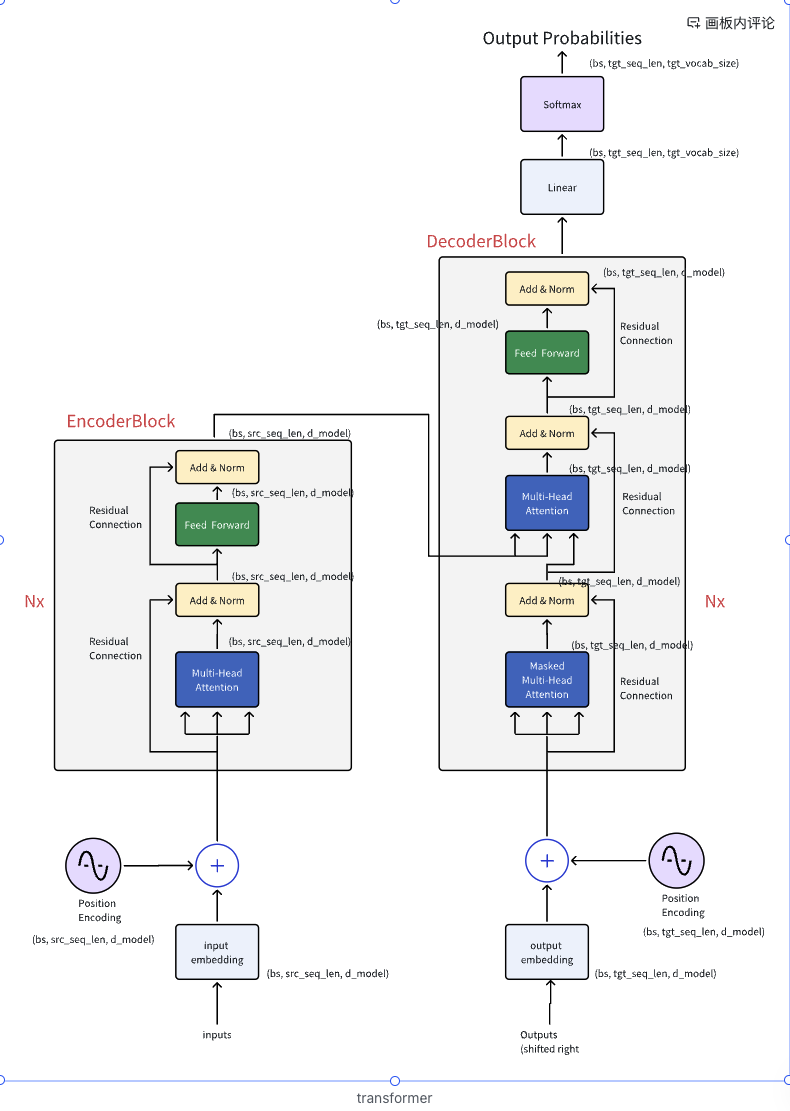



# 1 Input or Output Embedding
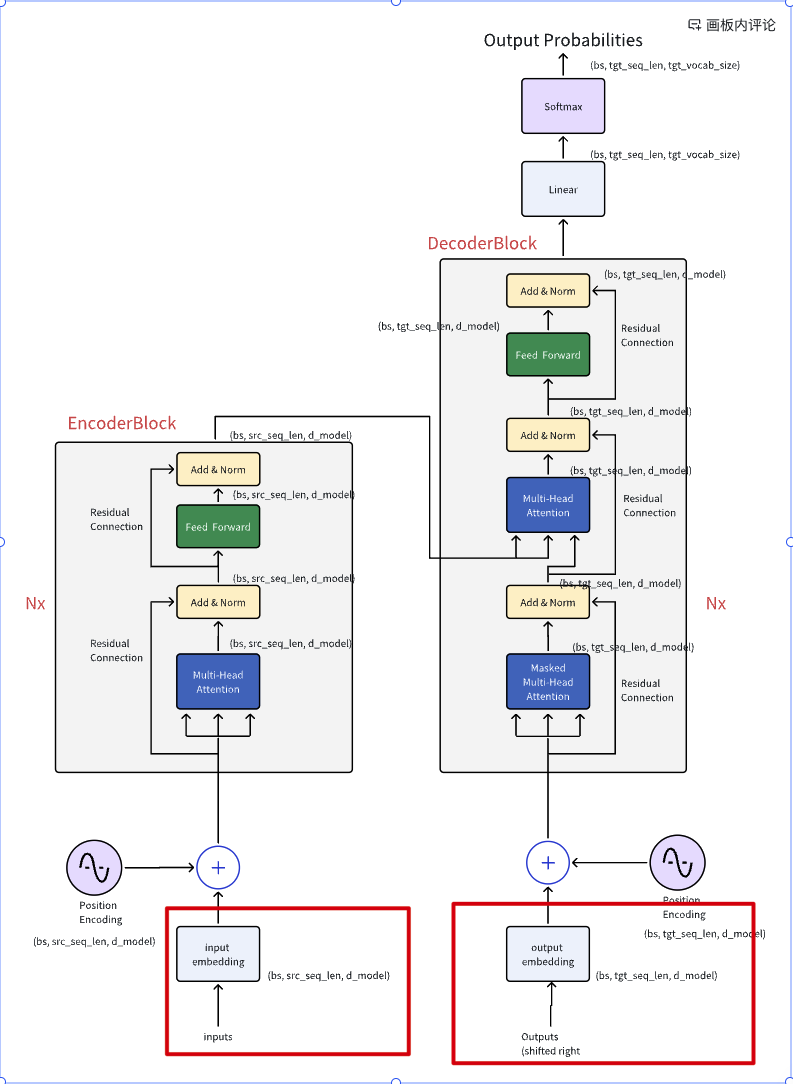
主要需要涉及词汇表，vocab_size， input 和 output的词汇表大小可能不同。
比如翻译 英文 -> 中文

In [11]:
import torch
import torch.nn as nn
import math

class InputEmbedding(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super(InputEmbedding, self).__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)
        

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)
    
    

# 2 位置编码
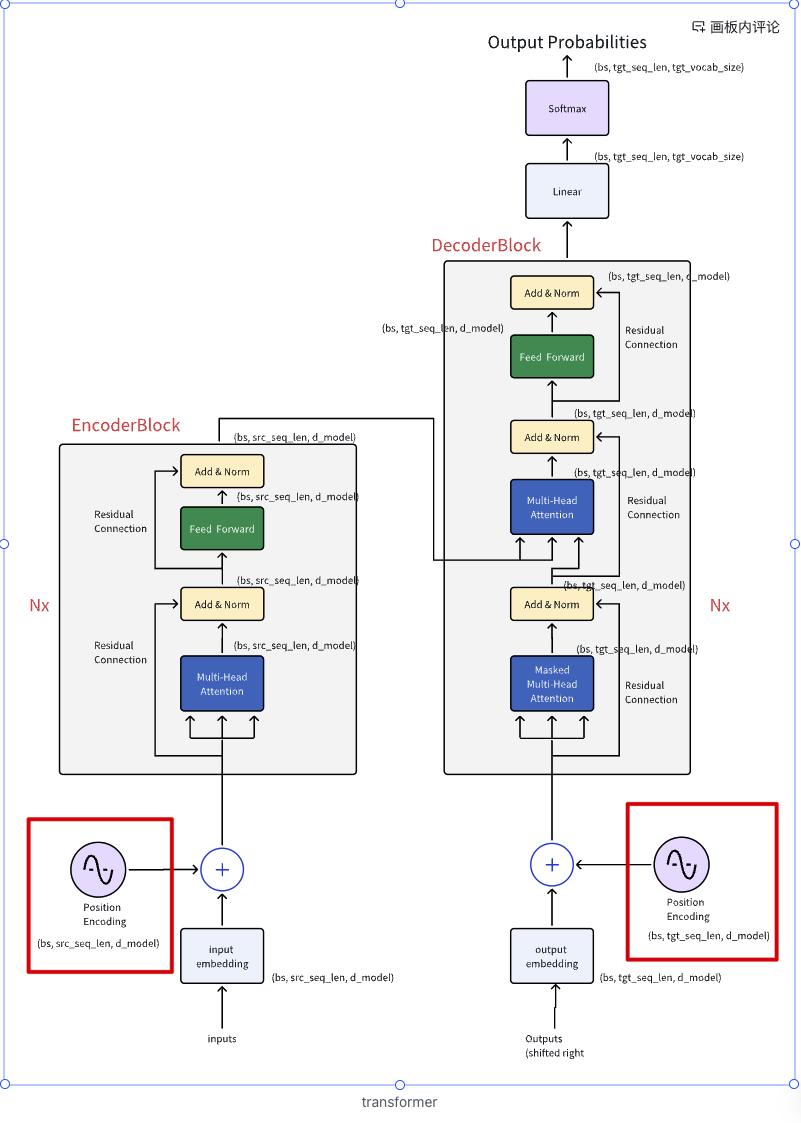

In [12]:
class PositionalEncoding(nn.Module):
    
    def __init__(self,  d_model: int, seq_len: int, dropout: float = 0.1):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        # 防止过拟合
        self.dropout = nn.Dropout(p=dropout)
        # Create the positional encoding matrix (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # create a vctor of shape (seq_len, 1)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Apply sine to even indices in the array; 2i
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in the array; 2i+1
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        self.register_buffer('pe', pe) # Register as buffer so it won't be considered a model parameter. 会一起写入到模型中去
    
    
    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        x = x + (self.pe[:, :x.size(1), :]).requires_grad_(False)
        return self.dropout(x)

# 3 LN 归一化

## 区别 BN VS LN

可以自己手写，也可以使用nn.LayerNorm()

输出： (batch_size, seq_len, d_model) -> (batch_size, seq_len, d_model)

In [13]:
class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 1e-6):
        super(LayerNormalization, self).__init__()
        # 防止方法过小，接近零，除以这个值得到一个巨大的值
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(1))
        self.beta = nn.Parameter(torch.zeros(1))
        

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

# 4 FFN 全连接神经网路层

d_ff 在论文中应该是 4 * d_model

输出： (batch, seq_length, d_model) -> (batch, seq_length, d_ff) -> (batch, seq_length, d_model)

In [14]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff) # W1 , B1
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model) # W2 , B2
        self.relu = nn.ReLU()
        # 在这里gpt2中使用的是gelu激活函数，而不是relu
        self.gelu = nn.GELU()

    def forward(self, x):
        # (batch, seq_length, d_model) -> (batch, seq_length, d_ff) -> (batch, seq_length, d_model)
        return self.linear2(self.dropout(self.relu(self.linear1(x))))
        

# 5 多头注意力机制
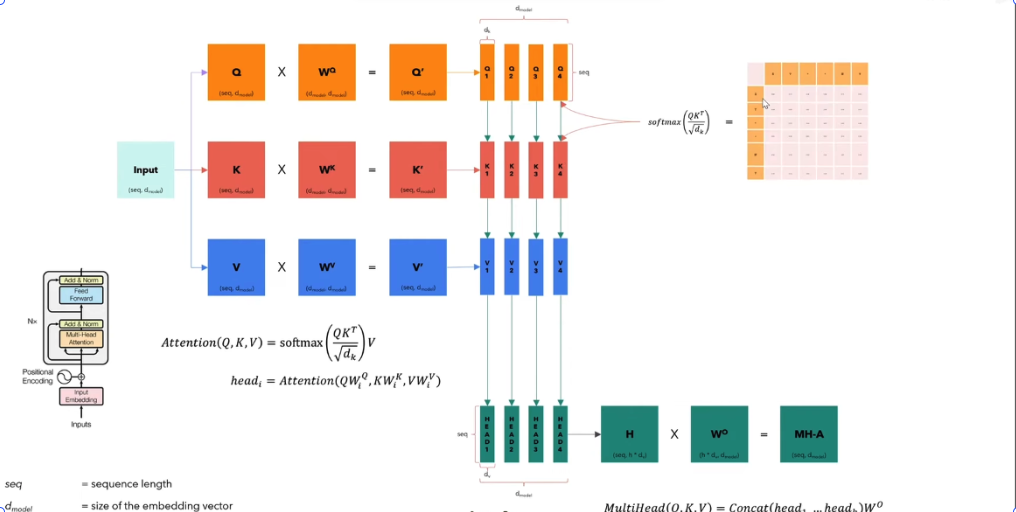 

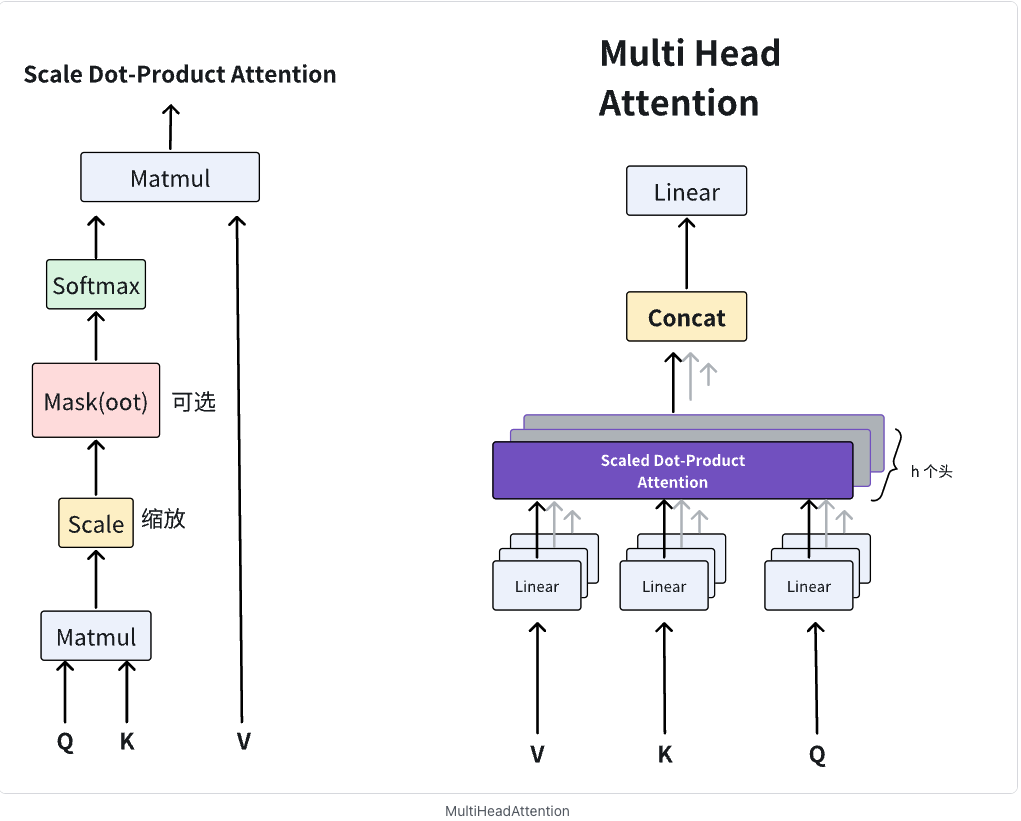

In [15]:
import torch.nn.functional as F
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads:int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        assert self.d_model % self.num_heads == 0, "d_model must be divisible by num_heads"
        self.d_k = d_model //  num_heads # 每个头的维度
        self.dropout = nn.Dropout(dropout)
        # 线性变换  Q *w _q = Q'
        # Q = (batch, seq_len, d_model) --> Q' = (batch, seq_len, d_model)
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        
        # 线性变换  K *w _k = K'
        # K = (batch, seq_len, d_model) --> K' = (batch, seq_len, d_model)
        self.w_k = nn.Linear(d_model, d_model, bias=False) # wk
        
        # 线性变换  V *w _v = V'
        # V = (batch, seq_len, d_model) --> V' = (batch, seq_len, d_model)
        self.w_v= nn.Linear(d_model, d_model, bias=False)
        
        self.w_o = nn.Linear(d_model, d_model, bias=False) # W_o
    
    
    @staticmethod
    def scaled_dot_product_attention(q, k, v, mask: None, dropout: nn.Dropout):
     
        # mask: (batch, seq_len, seq_len)
        # q, k, v: (batch, num_heads, seq_len,  d_k)
        attention = q @  k.transpose(-2, -1) / math.sqrt(q.shape[-1]) # (batch, num_heads, seq_len, seq_len)
        if mask is not None:
            attention.masked_fill(mask == 0, float('-inf')) # (batch, num_heads, seq_len, seq_len)
        
        attention_scores = F.softmax(attention, dim=-1) # (batch, num_heads, seq_len, seq_len)
        if dropout:
            attention_scores = dropout(attention_scores)
        #  attention_scores @ v : (batch, num_heads, seq_len, d_k) 
        return attention_scores @ v, attention_scores
    
    # mask 用于屏蔽词与某些词的交互
    def forward(self, q, k, v, mask: None):
        # q, k, v: (batch, seq_len, d_model)
        # x: (batch, seq_len, d_model)
        # mask: (batch, seq_len, seq_len)
        q = self.w_q(q)
        k = self.w_k(k)
        v = self.w_v(v)
        
        # q, k, v: (batch, seq_len, d_model) --> (batch, seq_len, num_heads, d_k)
        # 之所以调用transpose(1, 2) 是因为希望每个head都能看到整个句子
        q = q.view(q.shape[0], q.shape[1], self.num_heads, self.d_k).transpose(1, 2) # (batch, num_heads, seq_len, d_k)
        k = k.view(k.shape[0], k.shape[1], self.num_heads, self.d_k).transpose(1, 2) # (batch, num_heads, seq_len, d_k)
        v = v.view(v.shape[0], v.shape[1], self.num_heads, self.d_k).transpose(1, 2) # (batch, num_heads, seq_len, d_k)
        
        x, attention_scores = MultiHeadAttention.scaled_dot_product_attention(q, k, v, mask, self.dropout) # (batch, num_heads, seq_len, d_k)
        
        # merge heads 
        # (batch, num_heads, seq_len, d_k) --> (batch, seq_len, num_heads, d_k) -->(batch, seq_len, num_heads * d_k)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.d_model)
        
        # (batch, seq_ln, d_model) --> (batch, seq_len, d_model)
        x = self.w_o(x)
        return x
        
        
        

# 6 残差连接 residual connection

## post-norm 与 pre-norm


In [16]:
class ResidualConnection(nn.Module):
    
    def __init__(self, dropout: float = 0.1):
        
        super().__init__()
        self.norm = LayerNormalization()
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x, sublayer):
        # pre--normalization
        return x + self.dropout(sublayer(self.norm(x)))
    
        # post normalization
        # return self.norm(x + self.dropout(sublayer(x)))

# 7 EncoderBlock

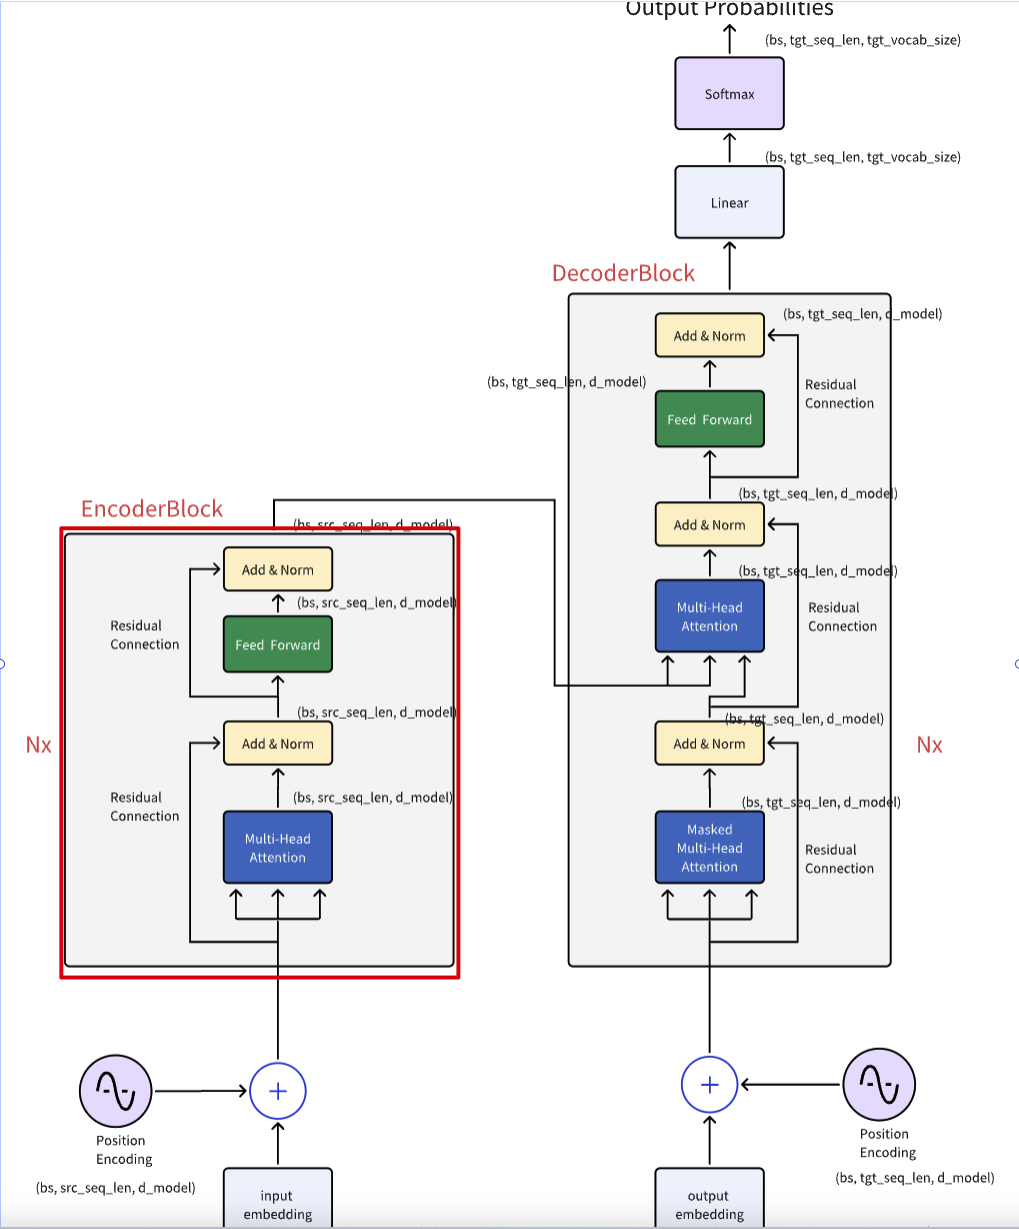

In [17]:
class EncoderBlock(nn.Module):
    def __init__(self, self_head_attention: MultiHeadAttention, feed_forward_block: FeedForwardBlock, dropout: float = 0.1):
        super().__init__()
        self.self_head_attention = self_head_attention
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList(
            [
                ResidualConnection(dropout=dropout) for _ in range(2)
            ]
        )
        
    def forward(self, x, src_mask):
        # x: (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        x = self.residual_connections[0](x, lambda x: self.self_head_attention(x, x, x, src_mask))
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        x = self.residual_connections[1](x, lambda x: self.feed_forward_block(x))
        return x

In [18]:

class Encoder(nn.Module):
    
    def __init__(self, layes: nn.ModuleList):
        super().__init__()
      
        
        self.layes = layes
        self.final_layer_norm = LayerNormalization()
        
    def forward(self, x, src_mask):
        
        for layer in self.layes:
            x = layer(x, src_mask)
        # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)    
        return self.final_layer_norm(x)

# 8 Decoder Block

In [19]:
class DecoderBlock(nn.Module):
    
    def __init__(self, self_attention_layer: MultiHeadAttention, cross_attention_layer: MultiHeadAttention, feed_forward_block: FeedForwardBlock, dropout: float = 0.1):
        
        super().__init__()
        self.self_attention_layer = self_attention_layer
        self.cross_attention_layer = cross_attention_layer
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList(
            [
                ResidualConnection(dropout=dropout) for _ in range(3)
            ]
        )

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # x: (batch, tgt_seq_len, d_model) --> (batch, tgt_seq_len, d_model)
        x = self.residual_connections[0](x, lambda x: self.self_attention_layer(x, x, x, tgt_mask))
        #  (batch, src_seq_len, d_model) --> (batch, tgt_seq_len, src_seq_len) --> (batch, tgt_seq_len, d_model) 
        
        x = self.residual_connections[1](x, lambda x: self.cross_attention_layer(x, enc_output, enc_output, src_mask))
        #  (batch, tgt_seq_len, d_model) --> (batch, tgt_seq_len, d_model) 
        x = self.residual_connections[2](x, lambda x: self.feed_forward_block(x))
        return x
        
        

In [20]:
class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.final_layer_norm = LayerNormalization()
    
    def forward(self, x, enc_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        # (batch_size, tgt_seq_len, d_model) --> (batch_size, tgt_seq_len, d_model)
        return self.final_layer_norm(x)
        

# 9 projection layer: linear & softmax


In [21]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size:int):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, vocab_size)
       
    
       
        
    def forward(self, x):
        
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        x = self.linear_1(x)
        x = F.softmax(x, dim = -1)
        return x
    

# 10 Transformer
五部分组成：
1. InputEmbedding, OutputEmbedding  
2. Position Encoding
3. Encoder
4. Decoder
5. ProjectionLayer

In [22]:
class Transformer(nn.Module):
    
    def __init__(self, 
                 src_embd: InputEmbedding, 
                 tgt_embd: InputEmbedding, 
                 src_pos_encoding: PositionalEncoding, 
                 tgt_pos_encoding: PositionalEncoding,
                 encoder: Encoder, 
                 decoder: Decoder,
                 projection: ProjectionLayer,
                 ):
        super().__init__()
        self.src_embd = src_embd
        self.tgt_embd = tgt_embd
        self.src_pos_encoding = src_pos_encoding
        self.tgt_pos_encoding = tgt_pos_encoding
        self.encoder = encoder
        self.decoder = decoder
        self.projection = projection

    def encode(self, src_inputs: torch.Tensor, src_mask: torch.Tensor):
        # (batch, src_seq_len) --> (batch, src_seq_len, d_model)
        src_inputs = self.src_embd(src_inputs)
        # (batch, src_seq_len, d_model) --> (batch, src_seq_len, d_model)
        src_inputs = self.src_pos_encoding(src_inputs)
        return self.encoder(src_inputs, src_mask)
    
    
    def decode(self, 
            
               encoder_outputs: torch.Tensor, 
               src_mask: torch.Tensor,
               tgt_inputs: torch.Tensor, 
               tgt_mask: torch.Tensor,
               ):
        # (batch, tgt_seq_len) --> (batch, tgt_seq_len, d_model)
        tgt_inputs = self.tgt_embd(tgt_inputs)
        # (batch, tgt_seq_len, d_model) --> (batch, tgt_seq_len, d_model)   
        tgt_inputs = self.tgt_pos_encoding(tgt_inputs)
        
        return self.decoder(tgt_inputs, encoder_outputs, src_mask, tgt_mask)
    
    def project(self, x):
        return self.projection(x)

# 11 build_transformer.py

In [23]:
def build_transformer(
    src_vocab_size,
    tgt_vocab_size,
    src_seq_len,
    tgt_seq_len,
    d_model: int = 512,
    num_layers: int= 6,
    num_heads: int = 8,
    d_ff: int = 2048,
    dropout: float = 0.1
) -> Transformer:
    
    # create embedding layer
    src_embd = InputEmbedding(d_model, src_vocab_size)
    tgt_embd = InputEmbedding(d_model, tgt_vocab_size)
    # create positional encoding layer
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # create encoder
    
    encoder_blocks = []
    for _ in range(num_layers):
        src_multi_head_attention = MultiHeadAttention(d_model, num_heads)
    
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(src_multi_head_attention, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)
    
    encoder = Encoder(nn.ModuleList(encoder_blocks))
     # decoder
    decoder_blocks = []
    for _ in range(num_layers):
        src_multi_head_attention = MultiHeadAttention(d_model, num_heads)
        tgt_multi_head_attention = MultiHeadAttention(d_model, num_heads)
        decoder_block = DecoderBlock(tgt_multi_head_attention, src_multi_head_attention, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
   
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    # projection layer
    projection = ProjectionLayer(d_model, tgt_vocab_size)
    
    
    transformer = Transformer(src_embd, tgt_embd, src_pos, tgt_pos, encoder, decoder, projection)
    
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer
    

In [24]:
10 ** -6 == 1e-6

True